Checking data setup...

Training sequences: 662
Validation sequences: 99

First few rows of processed training data:
                                   sequence      class_name  label
0  WIN_20180925_17_18_28_Pro_Left_Swipe_new  Left_Swipe_new      0
1  WIN_20180925_17_18_56_Pro_Left_Swipe_new  Left_Swipe_new      0
2  WIN_20180925_17_19_51_Pro_Left_Swipe_new  Left_Swipe_new      0
3  WIN_20180925_17_20_14_Pro_Left_Swipe_new  Left_Swipe_new      0
4  WIN_20180925_17_21_28_Pro_Left_Swipe_new  Left_Swipe_new      0

Training class distribution:
3    137
1    137
0    135
2    130
4    123
Name: label, dtype: int64

Checking data structure...

Train directory structure:
Number of sequences in train: 663

Sample sequence: WIN_20180925_17_26_58_Pro_Right_Swipe_new
Number of frames: 30
Frame names: ['WIN_20180925_17_26_58_Pro_00003.png', 'WIN_20180925_17_26_58_Pro_00005.png', 'WIN_20180925_17_26_58_Pro_00007.png', 'WIN_20180925_17_26_58_Pro_00009.png', 'WIN_20180925_17_26_58_Pro_00011.png']


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


41/41 [==============================] - 53s 1s/step - loss: 1.5871 - accuracy: 0.3247 - val_loss: 1.2129 - val_accuracy: 0.4792 - lr: 0.0010
Epoch 2/50
41/41 [==============================] - 46s 1s/step - loss: 1.1232 - accuracy: 0.5186 - val_loss: 0.9035 - val_accuracy: 0.6562 - lr: 0.0010
Epoch 3/50
41/41 [==============================] - 45s 1s/step - loss: 0.7988 - accuracy: 0.6873 - val_loss: 0.7399 - val_accuracy: 0.6979 - lr: 0.0010
Epoch 4/50
41/41 [==============================] - 44s 1s/step - loss: 0.6805 - accuracy: 0.7152 - val_loss: 0.6420 - val_accuracy: 0.7083 - lr: 0.0010
Epoch 5/50
41/41 [==============================] - 46s 1s/step - loss: 0.4422 - accuracy: 0.8266 - val_loss: 0.5365 - val_accuracy: 0.7708 - lr: 0.0010
Epoch 6/50
41/41 [==============================] - 47s 1s/step - loss: 0.4312 - accuracy: 0.8452 - val_loss: 0.9679 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 7/50
41/41 [==============================] - 46s 1s/step - loss: 0.4136 - accuracy: 0.

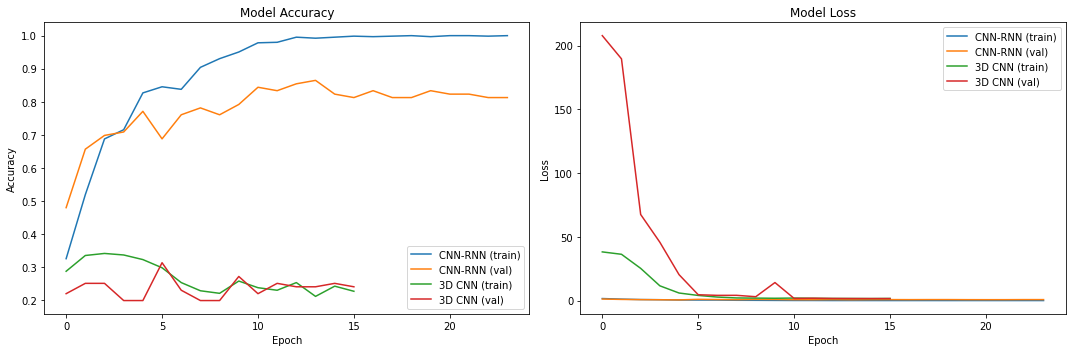


Training completed successfully!
Models saved as 'cnn_rnn_model.h5' and '3d_cnn_model.h5'


In [16]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, Conv3D, LSTM, Dense, Dropout, 
                                   MaxPool2D, MaxPool3D, BatchNormalization, 
                                   Flatten, TimeDistributed, GRU, GlobalAveragePooling2D)
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.utils import to_categorical
import cv2
import matplotlib.pyplot as plt

# Constants for directory paths
BASE_DIR = 'datasets/Project_data'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VAL_DIR = os.path.join(BASE_DIR, 'val')

class GestureGenerator:
    def __init__(self, directory_type='train', batch_size=16, n_frames=30, 
                 target_size=(120, 120), model_type='cnn_rnn'):
        self.batch_size = batch_size
        self.n_frames = n_frames
        self.target_size = target_size
        self.model_type = model_type
        
        # Map numeric labels to class names
        self.label_to_class = {
            0: 'Left_Swipe_new',
            1: 'Right_Swipe_new',
            2: 'Stop_new',
            3: 'Thumbs_Down_new',
            4: 'Thumbs_Up_new'
        }
        
        # Set appropriate directory and CSV file
        if directory_type == 'train':
            self.data_dir = TRAIN_DIR
            self.df = pd.read_csv(os.path.join(BASE_DIR, 'train.csv'), sep=';')
        else:  # val
            self.data_dir = VAL_DIR
            self.df = pd.read_csv(os.path.join(BASE_DIR, 'val.csv'), sep=';')
            
        # Extract sequence name and label from the data
        self.df = pd.DataFrame({
            'sequence': self.df.iloc[:, 0],
            'class_name': self.df.iloc[:, 1],
            'label': self.df.iloc[:, 2].astype(int)
        })
        
        print(f"\nInitialized {directory_type} generator:")
        print(f"Number of sequences: {len(self.df)}")
        print(f"Target frame size: {target_size}")
        print(f"Frames per sequence: {n_frames}")
        print(f"Batch size: {batch_size}")

    def preprocess_frame(self, frame):
        """Preprocess a single frame"""
        try:
            if frame is None:
                return np.zeros((*self.target_size, 3))
                
            # Convert BGR to RGB
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                
            # Maintain aspect ratio while resizing
            h, w = frame.shape[:2]
            scale = min(self.target_size[0]/h, self.target_size[1]/w)
            new_h, new_w = int(h*scale), int(w*scale)
            
            frame = cv2.resize(frame, (new_w, new_h))
            
            # Add padding if necessary
            delta_h = self.target_size[0] - new_h
            delta_w = self.target_size[1] - new_w
            top, bottom = delta_h//2, delta_h-(delta_h//2)
            left, right = delta_w//2, delta_w-(delta_w//2)
            
            frame = cv2.copyMakeBorder(frame, top, bottom, left, right, 
                                     cv2.BORDER_CONSTANT, value=[0,0,0])
            
            # Normalize
            frame = frame.astype(np.float32) / 255.0
            
            return frame
            
        except Exception as e:
            print(f"Error in preprocess_frame: {str(e)}")
            if isinstance(frame, np.ndarray):
                print(f"Frame shape: {frame.shape}")
            return np.zeros((*self.target_size, 3))
    
    def get_frame_paths(self, sequence_path):
        """Get sorted frame paths for a sequence"""
        try:
            # List all PNG files in the directory
            frame_files = [f for f in os.listdir(sequence_path) if f.endswith('.png')]
            
            # Sort frames by their number
            frame_files.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))
            
            # Get full paths
            frame_paths = [os.path.join(sequence_path, f) for f in frame_files]
            
            return frame_paths
        except Exception as e:
            print(f"Error getting frame paths for {sequence_path}: {str(e)}")
            return []
    
    def generate(self):
        """Generate batches of sequences"""
        while True:
            # Shuffle the dataset
            self.df = self.df.sample(frac=1).reset_index(drop=True)
            
            for i in range(0, len(self.df), self.batch_size):
                batch_df = self.df.iloc[i:min(i + self.batch_size, len(self.df))]
                batch_x = []
                batch_y = []
                
                for _, row in batch_df.iterrows():
                    sequence_path = os.path.join(self.data_dir, row['sequence'])
                    frame_paths = self.get_frame_paths(sequence_path)
                    
                    frames = []
                    # Take every nth frame to get exactly n_frames
                    step = max(1, len(frame_paths) // self.n_frames)
                    selected_paths = frame_paths[::step][:self.n_frames]
                    
                    for frame_path in selected_paths:
                        try:
                            frame = cv2.imread(frame_path)
                            if frame is None:
                                raise ValueError(f"Failed to load image: {frame_path}")
                            frame = self.preprocess_frame(frame)
                            frames.append(frame)
                        except Exception as e:
                            print(f"Error loading frame {frame_path}: {str(e)}")
                            frames.append(np.zeros((*self.target_size, 3)))
                    
                    # Pad sequence if necessary
                    while len(frames) < self.n_frames:
                        frames.append(np.zeros((*self.target_size, 3)))
                    
                    batch_x.append(frames[:self.n_frames])
                    batch_y.append(row['label'])
                
                if not batch_x:  # Skip empty batches
                    continue
                    
                batch_x = np.array(batch_x)
                batch_y = to_categorical(batch_y, num_classes=5)
                
                yield batch_x, batch_y

def test_generator():
    """Test the generator with a small batch"""
    print("\nTesting generator...")
    
    # Create test generator
    test_gen = GestureGenerator('train', batch_size=2)
    
    try:
        # Get a test batch
        batch_x, batch_y = next(test_gen.generate())
        
        print(f"Batch shapes:")
        print(f"X shape: {batch_x.shape}")
        print(f"y shape: {batch_y.shape}")
        print(f"X value range: [{batch_x.min():.3f}, {batch_x.max():.3f}]")
        
        # Display a sample frame
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10, 5))
        
        plt.subplot(1, 2, 1)
        plt.imshow(batch_x[0][0])
        plt.title("First frame of first sequence")
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(batch_x[0][-1])
        plt.title("Last frame of first sequence")
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        return True
    except Exception as e:
        print(f"Generator test failed: {str(e)}")
        import traceback
        traceback.print_exc()
        return False

def create_cnn_rnn_model(input_shape):
    """Create CNN-RNN model using MobileNetV2 + GRU"""
    # Base CNN model (MobileNetV2)
    base_cnn = MobileNetV2(
        input_shape=(input_shape[1], input_shape[2], 3),
        include_top=False,
        weights='imagenet'
    )
    
    # Freeze the base model
    base_cnn.trainable = False
    
    model = Sequential([
        # TimeDistributed wrapper applies the CNN to each frame
        TimeDistributed(base_cnn, input_shape=input_shape),
        TimeDistributed(GlobalAveragePooling2D()),
        
        # RNN layers
        GRU(256, return_sequences=True),
        Dropout(0.3),
        GRU(128),
        Dropout(0.3),
        
        # Output layer
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(5, activation='softmax')
    ])
    
    return model

def create_3d_cnn_model(input_shape):
    """Create 3D CNN model"""
    model = Sequential([
        # First 3D Conv Block
        Conv3D(32, kernel_size=(3, 3, 3), activation='relu', 
              input_shape=input_shape, padding='same'),
        MaxPool3D(pool_size=(1, 2, 2)),
        BatchNormalization(),
        
        # Second 3D Conv Block
        Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same'),
        MaxPool3D(pool_size=(1, 2, 2)),
        BatchNormalization(),
        
        # Third 3D Conv Block
        Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same'),
        MaxPool3D(pool_size=(1, 2, 2)),
        BatchNormalization(),
        
        # Fourth 3D Conv Block
        Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same'),
        MaxPool3D(pool_size=(1, 2, 2)),
        BatchNormalization(),
        
        # Flatten and Dense layers
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(5, activation='softmax')
    ])
    
    return model

def train_model(model, train_generator, val_generator, model_name):
    """Train the model with callbacks"""
    
    # Callbacks
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            f'{model_name}_best.h5',
            save_best_only=True,
            monitor='val_accuracy'
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=10,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5
        )
    ]
    
    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Calculate steps per epoch
    steps_per_epoch = len(train_generator.df) // train_generator.batch_size
    validation_steps = len(val_generator.df) // val_generator.batch_size
    
    # Train
    history = model.fit(
        train_generator.generate(),
        steps_per_epoch=steps_per_epoch,
        epochs=50,
        validation_data=val_generator.generate(),
        validation_steps=validation_steps,
        callbacks=callbacks
    )
    
    return history

def plot_training_history(cnn_rnn_history, cnn_3d_history):
    """Plot training histories for both models"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Accuracy plot
    ax1.plot(cnn_rnn_history.history['accuracy'], label='CNN-RNN (train)')
    ax1.plot(cnn_rnn_history.history['val_accuracy'], label='CNN-RNN (val)')
    ax1.plot(cnn_3d_history.history['accuracy'], label='3D CNN (train)')
    ax1.plot(cnn_3d_history.history['val_accuracy'], label='3D CNN (val)')
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend()
    
    # Loss plot
    ax2.plot(cnn_rnn_history.history['loss'], label='CNN-RNN (train)')
    ax2.plot(cnn_rnn_history.history['val_loss'], label='CNN-RNN (val)')
    ax2.plot(cnn_3d_history.history['loss'], label='3D CNN (train)')
    ax2.plot(cnn_3d_history.history['val_loss'], label='3D CNN (val)')
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

def verify_data_setup():
    """Verify data structure and print dataset information"""
    print("Checking data setup...")
    
    required_paths = [BASE_DIR, TRAIN_DIR, VAL_DIR]
    for path in required_paths:
        if not os.path.exists(path):
            raise FileNotFoundError(f"Required path does not exist: {path}")
    
    train_csv = os.path.join(BASE_DIR, 'train.csv')
    val_csv = os.path.join(BASE_DIR, 'val.csv')
    
    if not (os.path.exists(train_csv) and os.path.exists(val_csv)):
        raise FileNotFoundError("CSV files not found")
        
    # Read CSV with semicolon separator
    train_df = pd.read_csv(train_csv, sep=';')
    val_df = pd.read_csv(val_csv, sep=';')
    
    print(f"\nTraining sequences: {len(train_df)}")
    print(f"Validation sequences: {len(val_df)}")
    
    # Process the data
    train_df = pd.DataFrame({
        'sequence': train_df.iloc[:, 0],
        'class_name': train_df.iloc[:, 1],
        'label': train_df.iloc[:, 2].astype(int)
    })
    
    print("\nFirst few rows of processed training data:")
    print(train_df.head())
    print("\nTraining class distribution:")
    print(train_df['label'].value_counts())

    # Verify some sequences exist
    sample_sequence = train_df['sequence'].iloc[0]
    sample_path = os.path.join(TRAIN_DIR, sample_sequence)
    if not os.path.exists(sample_path):
        print(f"\nWARNING: Sample sequence path not found: {sample_path}")
        print("Available files in TRAIN_DIR:", os.listdir(TRAIN_DIR)[:5])

def check_data_structure():
    print("\nChecking data structure...")
    
    # Check train directory
    print("\nTrain directory structure:")
    train_sequences = os.listdir(TRAIN_DIR)
    print(f"Number of sequences in train: {len(train_sequences)}")
    if train_sequences:
        sample_sequence = train_sequences[0]
        sample_path = os.path.join(TRAIN_DIR, sample_sequence)
        print(f"\nSample sequence: {sample_sequence}")
        if os.path.isdir(sample_path):
            frames = sorted(os.listdir(sample_path))
            print(f"Number of frames: {len(frames)}")
            print("Frame names:", frames[:5])
    
    # Check validation directory
    print("\nValidation directory structure:")
    val_sequences = os.listdir(VAL_DIR)
    print(f"Number of sequences in val: {len(val_sequences)}")
    if val_sequences:
        sample_sequence = val_sequences[0]
        sample_path = os.path.join(VAL_DIR, sample_sequence)
        print(f"\nSample sequence: {sample_sequence}")
        if os.path.isdir(sample_path):
            frames = sorted(os.listdir(sample_path))
            print(f"Number of frames: {len(frames)}")
            print("Frame names:", frames[:5])

            

if __name__ == "__main__":
    try:
        # Verify data setup
        verify_data_setup()
        
        # Check actual data structure
        check_data_structure()
        
        # Set input shape and batch size
        input_shape = (30, 120, 120, 3)  # (frames, height, width, channels)
        batch_size = 16
        
        # Create generators for CNN-RNN
        train_gen_cnn_rnn = GestureGenerator('train', batch_size=batch_size, model_type='cnn_rnn')
        val_gen_cnn_rnn = GestureGenerator('val', batch_size=batch_size, model_type='cnn_rnn')
        
        # Test generator
        print("\nTesting CNN-RNN generator...")
        test_batch = next(train_gen_cnn_rnn.generate())
        print(f"CNN-RNN Batch shapes: X={test_batch[0].shape}, y={test_batch[1].shape}")
        
        # Train CNN-RNN model
        print("\nTraining CNN-RNN model...")
        cnn_rnn_model = create_cnn_rnn_model(input_shape)
        cnn_rnn_history = train_model(cnn_rnn_model, train_gen_cnn_rnn, 
                                    val_gen_cnn_rnn, 'cnn_rnn')
        
        # Create generators for 3D CNN
        train_gen_3d = GestureGenerator('train', batch_size=batch_size, model_type='3d_cnn')
        val_gen_3d = GestureGenerator('val', batch_size=batch_size, model_type='3d_cnn')
        
        # Test 3D CNN generator
        print("\nTesting 3D CNN generator...")
        test_batch_3d = next(train_gen_3d.generate())
        print(f"3D CNN Batch shapes: X={test_batch_3d[0].shape}, y={test_batch_3d[1].shape}")
        
        # Train 3D CNN model
        print("\nTraining 3D CNN model...")
        cnn_3d_model = create_3d_cnn_model(input_shape)
        cnn_3d_history = train_model(cnn_3d_model, train_gen_3d, 
                                   val_gen_3d, '3d_cnn')
        
        # Save models
        cnn_rnn_model.save('cnn_rnn_model.h5')
        cnn_3d_model.save('3d_cnn_model.h5')
        
        # Plot results
        plot_training_history(cnn_rnn_history, cnn_3d_history)
        
        print("\nTraining completed successfully!")
        print("Models saved as 'cnn_rnn_model.h5' and '3d_cnn_model.h5'")
        
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        import traceback
        traceback.print_exc()

Checking data setup...

Training sequences: 662
Validation sequences: 99

First few rows of processed training data:
                                   sequence      class_name  label
0  WIN_20180925_17_18_28_Pro_Left_Swipe_new  Left_Swipe_new      0
1  WIN_20180925_17_18_56_Pro_Left_Swipe_new  Left_Swipe_new      0
2  WIN_20180925_17_19_51_Pro_Left_Swipe_new  Left_Swipe_new      0
3  WIN_20180925_17_20_14_Pro_Left_Swipe_new  Left_Swipe_new      0
4  WIN_20180925_17_21_28_Pro_Left_Swipe_new  Left_Swipe_new      0

Training class distribution:
3    137
1    137
0    135
2    130
4    123
Name: label, dtype: int64

Checking data structure...

Train directory structure:
Number of sequences in train: 663

Sample sequence: WIN_20180925_17_26_58_Pro_Right_Swipe_new
Number of frames: 30
Frame names: ['WIN_20180925_17_26_58_Pro_00003.png', 'WIN_20180925_17_26_58_Pro_00005.png', 'WIN_20180925_17_26_58_Pro_00007.png', 'WIN_20180925_17_26_58_Pro_00009.png', 'WIN_20180925_17_26_58_Pro_00011.png']


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


41/41 [==============================] - 52s 1s/step - loss: 1.5976 - accuracy: 0.3155 - val_loss: 1.2041 - val_accuracy: 0.4375 - lr: 0.0010
Epoch 2/50
41/41 [==============================] - 46s 1s/step - loss: 1.1358 - accuracy: 0.5108 - val_loss: 0.8563 - val_accuracy: 0.6146 - lr: 0.0010
Epoch 3/50
41/41 [==============================] - 45s 1s/step - loss: 0.8268 - accuracy: 0.6610 - val_loss: 0.8495 - val_accuracy: 0.6458 - lr: 0.0010
Epoch 4/50
41/41 [==============================] - 45s 1s/step - loss: 0.7314 - accuracy: 0.7028 - val_loss: 0.7434 - val_accuracy: 0.7292 - lr: 0.0010
Epoch 5/50
41/41 [==============================] - 45s 1s/step - loss: 0.5740 - accuracy: 0.7740 - val_loss: 0.6953 - val_accuracy: 0.7188 - lr: 0.0010
Epoch 6/50
41/41 [==============================] - 45s 1s/step - loss: 0.3953 - accuracy: 0.8669 - val_loss: 0.7182 - val_accuracy: 0.7708 - lr: 0.0010
Epoch 7/50
41/41 [==============================] - 45s 1s/step - loss: 0.4075 - accuracy: 0.

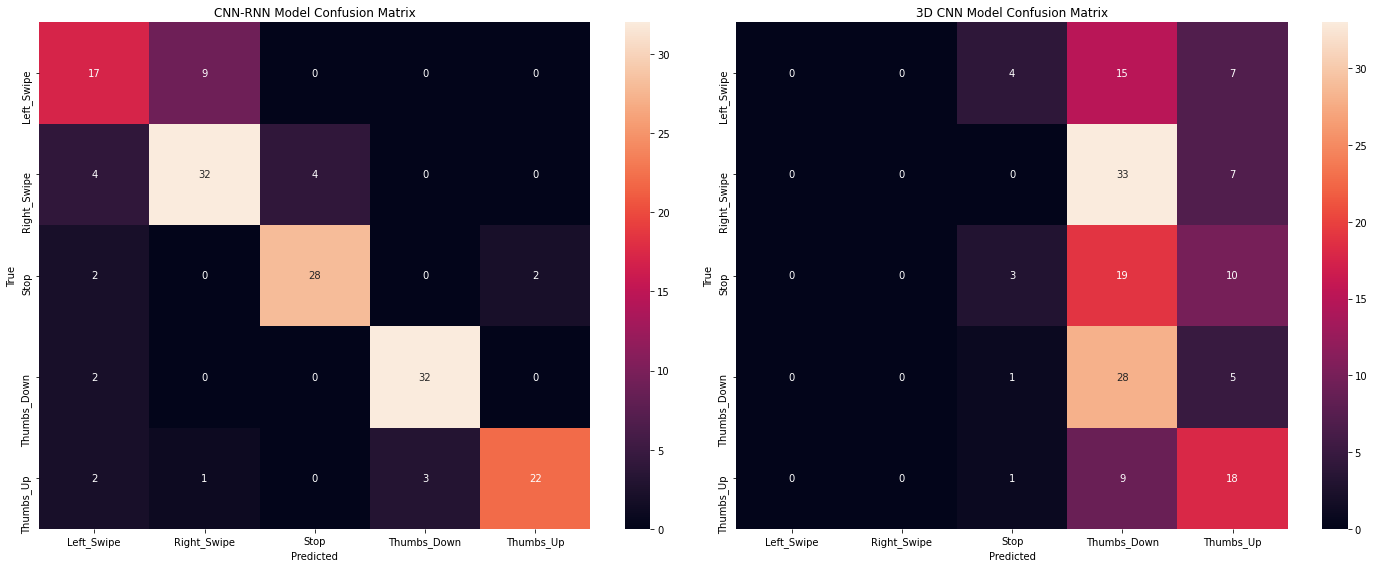


Plotting training history...


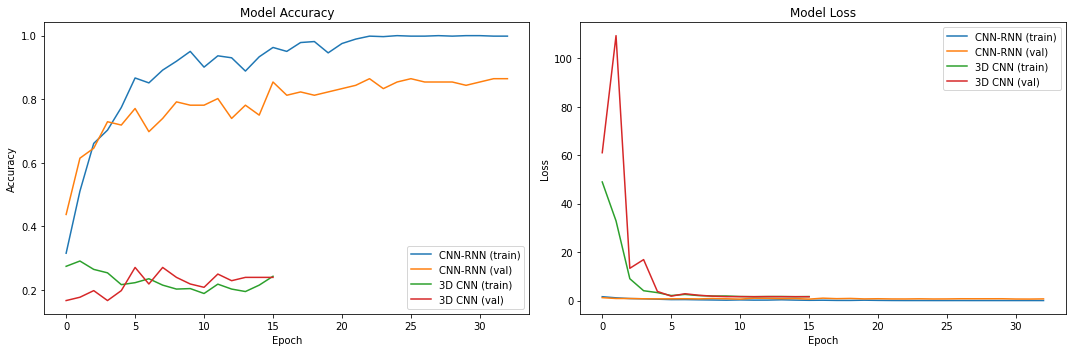


Visualizing CNN-RNN predictions...


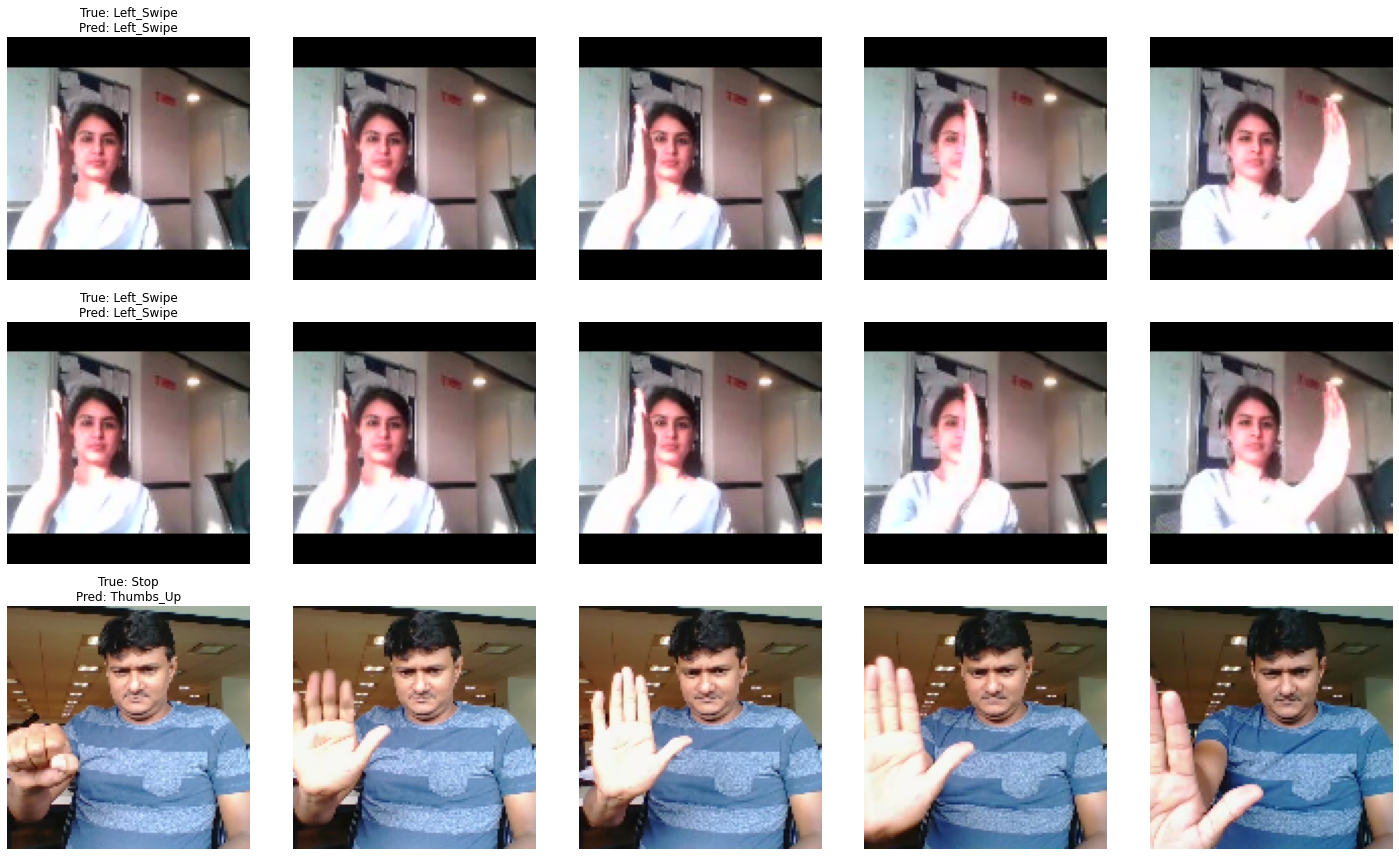


Fine-tuning CNN-RNN model...
Epoch 1/20
41/41 [==============================] - 56s 1s/step - loss: 1.6897 - accuracy: 0.6555 - val_loss: 0.7513 - val_accuracy: 0.8333
Epoch 2/20
41/41 [==============================] - 46s 1s/step - loss: 1.2938 - accuracy: 0.7136 - val_loss: 0.8589 - val_accuracy: 0.8125
Epoch 3/20
41/41 [==============================] - 51s 1s/step - loss: 0.8167 - accuracy: 0.7724 - val_loss: 0.7955 - val_accuracy: 0.8229
Epoch 4/20
41/41 [==============================] - 46s 1s/step - loss: 0.7717 - accuracy: 0.8127 - val_loss: 0.7176 - val_accuracy: 0.8542
Epoch 5/20
41/41 [==============================] - 48s 1s/step - loss: 0.5263 - accuracy: 0.8529 - val_loss: 0.7143 - val_accuracy: 0.8333
Epoch 6/20
41/41 [==============================] - 47s 1s/step - loss: 0.5210 - accuracy: 0.8514 - val_loss: 0.7383 - val_accuracy: 0.8333
Epoch 7/20
41/41 [==============================] - 45s 1s/step - loss: 0.3724 - accuracy: 0.8994 - val_loss: 0.6950 - val_accurac

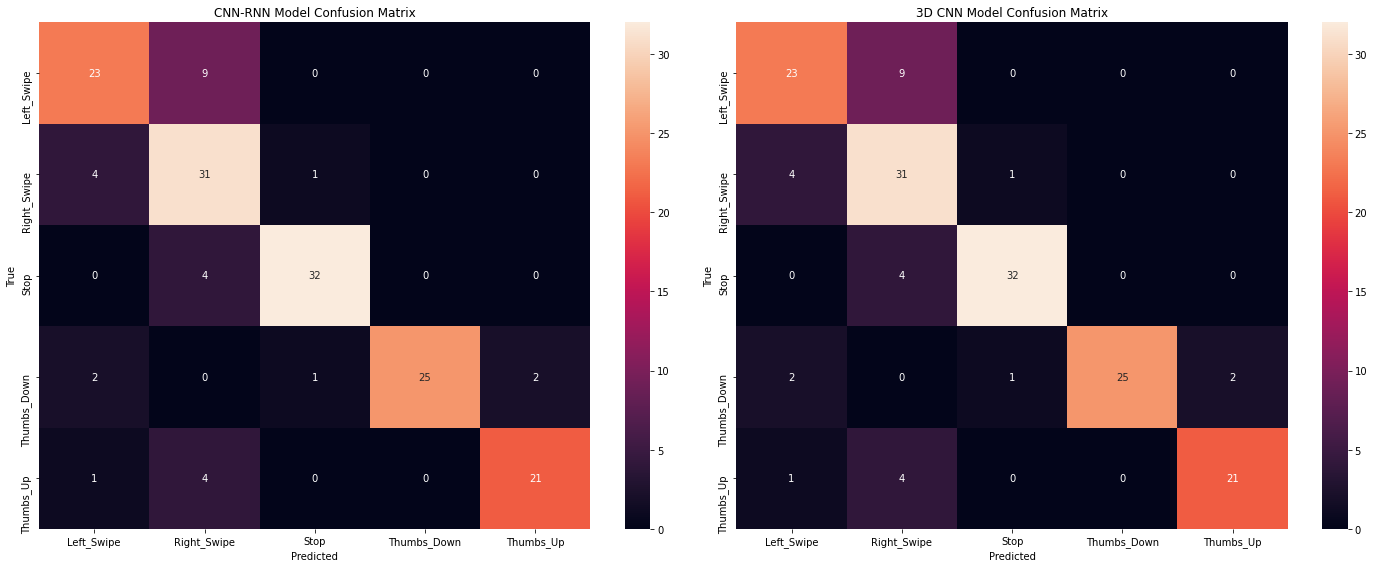


Saving fine-tuned model...


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


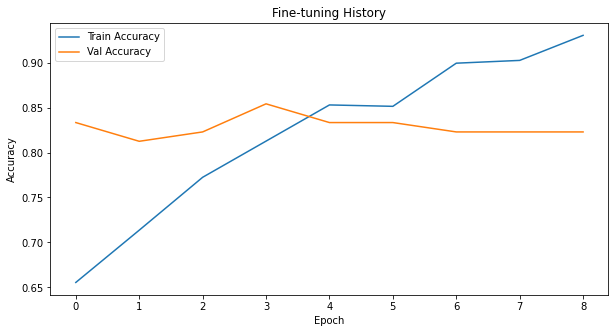


Evaluation and fine-tuning completed successfully!
Fine-tuned model saved as 'cnn_rnn_model_fine_tuned.h5'


In [18]:
# Add these imports at the top of your file
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (Conv2D, Conv3D, LSTM, Dense, Dropout, 
                                   MaxPool2D, MaxPool3D, BatchNormalization, 
                                   Flatten, TimeDistributed, GRU, GlobalAveragePooling2D)
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.utils import to_categorical
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix



def evaluate_models(cnn_rnn_model, cnn_3d_model, test_generator, class_names):
    """Evaluate both models on test data"""
    print("\nEvaluating Models...")
    
    # Collect predictions for multiple batches
    n_batches = 5  # Adjust based on your needs
    all_y_true = []
    all_y_pred_cnn_rnn = []
    all_y_pred_3d_cnn = []
    
    for _ in range(n_batches):
        try:
            X_test, y_test = next(test_generator.generate())
            
            # Make predictions
            cnn_rnn_pred = cnn_rnn_model.predict(X_test, verbose=0)
            cnn_3d_pred = cnn_3d_model.predict(X_test, verbose=0)
            
            # Convert to class labels
            y_true = np.argmax(y_test, axis=1)
            y_pred_cnn_rnn = np.argmax(cnn_rnn_pred, axis=1)
            y_pred_3d_cnn = np.argmax(cnn_3d_pred, axis=1)
            
            # Append to lists
            all_y_true.extend(y_true)
            all_y_pred_cnn_rnn.extend(y_pred_cnn_rnn)
            all_y_pred_3d_cnn.extend(y_pred_3d_cnn)
            
        except Exception as e:
            print(f"Error in batch processing: {str(e)}")
            continue
    
    # Convert lists to arrays
    all_y_true = np.array(all_y_true)
    all_y_pred_cnn_rnn = np.array(all_y_pred_cnn_rnn)
    all_y_pred_3d_cnn = np.array(all_y_pred_3d_cnn)
    
    # Print classification reports
    print("\nCNN-RNN Model Performance:")
    print(classification_report(all_y_true, all_y_pred_cnn_rnn, 
                              target_names=class_names, zero_division=1))
    
    print("\n3D CNN Model Performance:")
    print(classification_report(all_y_true, all_y_pred_3d_cnn, 
                              target_names=class_names, zero_division=1))
    
    # Plot confusion matrices
    plot_confusion_matrices(all_y_true, all_y_pred_cnn_rnn, 
                          all_y_pred_3d_cnn, class_names)
    
    return all_y_true, all_y_pred_cnn_rnn, all_y_pred_3d_cnn

def plot_confusion_matrices(y_true, y_pred_cnn_rnn, y_pred_3d_cnn, class_names):
    """Plot confusion matrices for both models"""
    try:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
        
        # CNN-RNN Confusion Matrix
        cm_cnn_rnn = confusion_matrix(y_true, y_pred_cnn_rnn)
        sns.heatmap(cm_cnn_rnn, annot=True, fmt='d', ax=ax1, 
                    xticklabels=class_names, yticklabels=class_names)
        ax1.set_title('CNN-RNN Model Confusion Matrix')
        ax1.set_xlabel('Predicted')
        ax1.set_ylabel('True')
        
        # 3D CNN Confusion Matrix
        cm_3d_cnn = confusion_matrix(y_true, y_pred_3d_cnn)
        sns.heatmap(cm_3d_cnn, annot=True, fmt='d', ax=ax2,
                    xticklabels=class_names, yticklabels=class_names)
        ax2.set_title('3D CNN Model Confusion Matrix')
        ax2.set_xlabel('Predicted')
        ax2.set_ylabel('True')
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error in plotting confusion matrices: {str(e)}")


def visualize_predictions(model, test_generator, class_names):
    """Visualize predictions on sample sequences"""
    X_test, y_test = next(test_generator.generate())
    predictions = model.predict(X_test)
    
    # Plot 3 random sequences
    fig, axes = plt.subplots(3, 5, figsize=(20, 12))
    for i in range(3):
        idx = np.random.randint(len(X_test))
        sequence = X_test[idx]
        true_label = np.argmax(y_test[idx])
        pred_label = np.argmax(predictions[idx])
        
        # Plot 5 frames from the sequence
        frame_indices = np.linspace(0, len(sequence)-1, 5, dtype=int)
        for j, frame_idx in enumerate(frame_indices):
            axes[i, j].imshow(sequence[frame_idx])
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(f'True: {class_names[true_label]}\nPred: {class_names[pred_label]}')
    
    plt.tight_layout()
    plt.show()

def fine_tune_model(model, train_generator, val_generator, learning_rate=1e-5):
    """Fine-tune the model with a lower learning rate"""
    # Unfreeze some layers for fine-tuning
    if isinstance(model.layers[0], TimeDistributed):
        base_model = model.layers[0].layer
        base_model.trainable = True
        # Freeze first few layers
        for layer in base_model.layers[:100]:
            layer.trainable = False
    
    # Compile with lower learning rate
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Train with early stopping
    history = model.fit(
        train_generator.generate(),
        steps_per_epoch=len(train_generator.df) // train_generator.batch_size,
        epochs=20,
        validation_data=val_generator.generate(),
        validation_steps=len(val_generator.df) // val_generator.batch_size,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor='val_accuracy',
                patience=5,
                restore_best_weights=True
            )
        ]
    )
    
    return history

if __name__ == "__main__":
    try:
        # Verify data setup
        verify_data_setup()
        
        # Check actual data structure
        check_data_structure()
        
        # Set input shape and batch size
        input_shape = (30, 120, 120, 3)  # (frames, height, width, channels)
        batch_size = 16
        
        # Create generators for CNN-RNN
        train_gen_cnn_rnn = GestureGenerator('train', batch_size=batch_size, model_type='cnn_rnn')
        val_gen_cnn_rnn = GestureGenerator('val', batch_size=batch_size, model_type='cnn_rnn')
        
        # Test generator
        print("\nTesting CNN-RNN generator...")
        test_batch = next(train_gen_cnn_rnn.generate())
        print(f"CNN-RNN Batch shapes: X={test_batch[0].shape}, y={test_batch[1].shape}")
        
        # Train CNN-RNN model
        print("\nTraining CNN-RNN model...")
        cnn_rnn_model = create_cnn_rnn_model(input_shape)
        cnn_rnn_history = train_model(cnn_rnn_model, train_gen_cnn_rnn, 
                                    val_gen_cnn_rnn, 'cnn_rnn')
        
        # Create generators for 3D CNN
        train_gen_3d = GestureGenerator('train', batch_size=batch_size, model_type='3d_cnn')
        val_gen_3d = GestureGenerator('val', batch_size=batch_size, model_type='3d_cnn')
        
        # Test 3D CNN generator
        print("\nTesting 3D CNN generator...")
        test_batch_3d = next(train_gen_3d.generate())
        print(f"3D CNN Batch shapes: X={test_batch_3d[0].shape}, y={test_batch_3d[1].shape}")
        
        # Train 3D CNN model
        print("\nTraining 3D CNN model...")
        cnn_3d_model = create_3d_cnn_model(input_shape)
        cnn_3d_history = train_model(cnn_3d_model, train_gen_3d, 
                                   val_gen_3d, '3d_cnn')
        
        # Save initial models
        print("\nSaving initial models...")
        cnn_rnn_model.save('cnn_rnn_model.h5')
        cnn_3d_model.save('3d_cnn_model.h5')
        
        # Define class names
        class_names = ['Left_Swipe', 'Right_Swipe', 'Stop', 'Thumbs_Down', 'Thumbs_Up']
        
        # Create test generator
        print("\nCreating test generator...")
        test_gen = GestureGenerator('val', batch_size=32)
        
        # Evaluate models
        print("\nEvaluating models...")
        y_true, y_pred_cnn_rnn, y_pred_3d_cnn = evaluate_models(
            cnn_rnn_model, cnn_3d_model, test_gen, class_names
        )
        
        # Plot training history
        print("\nPlotting training history...")
        plot_training_history(cnn_rnn_history, cnn_3d_history)
        
        # Visualize predictions
        print("\nVisualizing CNN-RNN predictions...")
        visualize_predictions(cnn_rnn_model, test_gen, class_names)
        
        # Fine-tune CNN-RNN model
        print("\nFine-tuning CNN-RNN model...")
        fine_tune_history = fine_tune_model(cnn_rnn_model, train_gen_cnn_rnn, val_gen_cnn_rnn)
        
        # Evaluate fine-tuned model
        print("\nEvaluating fine-tuned model...")
        test_gen_final = GestureGenerator('val', batch_size=32)
        y_true_final, y_pred_final, _ = evaluate_models(
            cnn_rnn_model, cnn_rnn_model, test_gen_final, class_names
        )
        
        # Save fine-tuned model
        print("\nSaving fine-tuned model...")
        cnn_rnn_model.save('cnn_rnn_model_fine_tuned.h5')
        
        # Plot fine-tuning history
        plt.figure(figsize=(10, 5))
        plt.plot(fine_tune_history.history['accuracy'], label='Train Accuracy')
        plt.plot(fine_tune_history.history['val_accuracy'], label='Val Accuracy')
        plt.title('Fine-tuning History')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
        
        print("\nEvaluation and fine-tuning completed successfully!")
        print("Fine-tuned model saved as 'cnn_rnn_model_fine_tuned.h5'")
        
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        import traceback
        traceback.print_exc()

Loading model...

Testing on sample sequence...

Initialized val generator:
Number of sequences: 99
Target frame size: (120, 120)
Frames per sequence: 30
Batch size: 1
Processing sequence: WIN_20180926_17_01_52_Pro_Right_Swipe_new
Found 30 frames


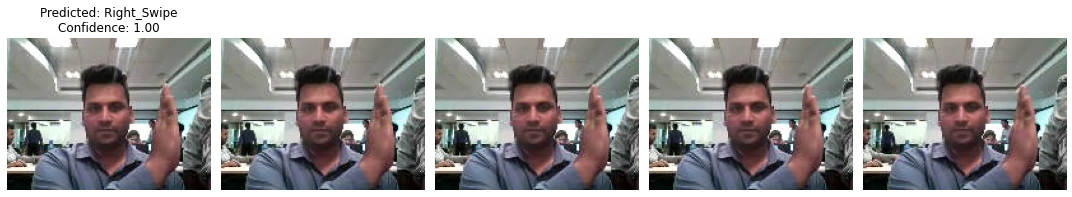


Testing on multiple sequences...

Initialized val generator:
Number of sequences: 99
Target frame size: (120, 120)
Frames per sequence: 30
Batch size: 1
Processing sequence: WIN_20180926_17_01_52_Pro_Right_Swipe_new
Found 30 frames

Sequence: WIN_20180926_17_01_52_Pro_Right_Swipe_new
Predicted: Right_Swipe
Confidence: 1.00

Initialized val generator:
Number of sequences: 99
Target frame size: (120, 120)
Frames per sequence: 30
Batch size: 1
Processing sequence: WIN_20180925_17_35_04_Pro_Thumbs_Up_new
Found 30 frames

Sequence: WIN_20180925_17_35_04_Pro_Thumbs_Up_new
Predicted: Thumbs_Up
Confidence: 1.00

Initialized val generator:
Number of sequences: 99
Target frame size: (120, 120)
Frames per sequence: 30
Batch size: 1
Processing sequence: WIN_20180926_16_46_22_Pro_Left_Swipe_new
Found 30 frames

Sequence: WIN_20180926_16_46_22_Pro_Left_Swipe_new
Predicted: Left_Swipe
Confidence: 0.92

Initialized val generator:
Number of sequences: 99
Target frame size: (120, 120)
Frames per sequen

[ WARN:0@7676.795] global /io/opencv/modules/videoio/src/cap_v4l.cpp (889) open VIDEOIO(V4L2:/dev/video0): can't open camera by index


In [19]:
import os
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

def predict_single_sequence(model, sequence_path, class_names):
    """
    Predict gesture for a single video sequence
    """
    try:
        # Create a temporary generator for single sequence
        generator = GestureGenerator('val', batch_size=1)
        
        # Load and preprocess frames
        frames = []
        frame_files = sorted(os.listdir(sequence_path))
        
        print(f"Processing sequence: {os.path.basename(sequence_path)}")
        print(f"Found {len(frame_files)} frames")
        
        for frame_file in frame_files:
            if frame_file.endswith('.png'):
                frame_path = os.path.join(sequence_path, frame_file)
                frame = cv2.imread(frame_path)
                if frame is not None:
                    frame = generator.preprocess_frame(frame)
                    frames.append(frame)
        
        # Ensure we have the correct number of frames
        frames = frames[:generator.n_frames]
        while len(frames) < generator.n_frames:
            frames.append(np.zeros_like(frames[0]))
        
        # Convert to numpy array and add batch dimension
        frames = np.array([frames])
        
        # Make prediction
        prediction = model.predict(frames, verbose=0)
        predicted_class = np.argmax(prediction[0])
        confidence = prediction[0][predicted_class]
        
        return class_names[predicted_class], confidence
        
    except Exception as e:
        print(f"Error in prediction: {str(e)}")
        return None, 0.0

def visualize_prediction_sequence(model, sequence_path, class_names):
    """
    Visualize prediction with frame sequence
    """
    try:
        # Get prediction
        predicted_class, confidence = predict_single_sequence(model, sequence_path, class_names)
        
        # Load frames
        frame_files = sorted([f for f in os.listdir(sequence_path) if f.endswith('.png')])
        n_frames = min(5, len(frame_files))  # Show 5 frames or less
        
        # Create figure
        plt.figure(figsize=(15, 3))
        
        # Plot frames
        for i in range(n_frames):
            frame_path = os.path.join(sequence_path, frame_files[i])
            frame = cv2.imread(frame_path)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            plt.subplot(1, n_frames, i+1)
            plt.imshow(frame)
            plt.axis('off')
            
            if i == 0:
                plt.title(f'Predicted: {predicted_class}\nConfidence: {confidence:.2f}')
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error in visualization: {str(e)}")

def real_time_prediction(model, class_names, confidence_threshold=0.7):
    """
    Real-time prediction using webcam
    """
    try:
        cap = cv2.VideoCapture(0)
        frames = []
        
        print("Starting real-time prediction (press 'q' to quit)...")
        print(f"Confidence threshold: {confidence_threshold}")
        
        while True:
            ret, frame = cap.read()
            if not ret:
                break
                
            # Preprocess frame
            generator = GestureGenerator('val', batch_size=1)
            processed_frame = generator.preprocess_frame(frame)
            
            # Add frame to sequence
            frames.append(processed_frame)
            frames = frames[-30:]  # Keep last 30 frames
            
            # Make prediction when we have enough frames
            if len(frames) == 30:
                sequence = np.array([frames])
                prediction = model.predict(sequence, verbose=0)
                predicted_class = np.argmax(prediction[0])
                confidence = prediction[0][predicted_class]
                
                # Display prediction if confidence is above threshold
                if confidence > confidence_threshold:
                    label = f"{class_names[predicted_class]} ({confidence:.2f})"
                    cv2.putText(frame, label, (10, 30), 
                              cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            
            # Display frame
            cv2.imshow('Real-time Gesture Recognition', frame)
            
            # Break loop on 'q' press
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
                
        cap.release()
        cv2.destroyAllWindows()
        
    except Exception as e:
        print(f"Error in real-time prediction: {str(e)}")
        if 'cap' in locals():
            cap.release()
        cv2.destroyAllWindows()

# Main execution block for testing
if __name__ == "__main__":
    try:
        # Load the fine-tuned model
        print("Loading model...")
        model = tf.keras.models.load_model('cnn_rnn_model_fine_tuned.h5')
        
        # Define class names
        class_names = ['Left_Swipe', 'Right_Swipe', 'Stop', 'Thumbs_Down', 'Thumbs_Up']
        
        # Test on a sample sequence
        print("\nTesting on sample sequence...")
        sample_sequence_path = os.path.join(VAL_DIR, os.listdir(VAL_DIR)[0])
        visualize_prediction_sequence(model, sample_sequence_path, class_names)
        
        # Test multiple sequences
        print("\nTesting on multiple sequences...")
        test_sequences = os.listdir(VAL_DIR)[:5]  # Test first 5 sequences
        
        for sequence in test_sequences:
            sequence_path = os.path.join(VAL_DIR, sequence)
            predicted_class, confidence = predict_single_sequence(
                model, sequence_path, class_names
            )
            print(f"\nSequence: {sequence}")
            print(f"Predicted: {predicted_class}")
            print(f"Confidence: {confidence:.2f}")
        
        # Start real-time prediction
        print("\nStarting real-time prediction...")
        real_time_prediction(model, class_names)
        
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        import traceback
        traceback.print_exc()